In [1]:
# Pandas library for the pandas dataframes
import pandas as pd
from pandas import DataFrame
import numpy as np
import scipy.stats as stats
import scipy



# Import Scikit-Learn library for decision tree models
import sklearn 

from sklearn import datasets, linear_model, metrics, tree
from sklearn.utils import resample

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor

from sklearn.linear_model import ElasticNet, Lasso,  RidgeCV

from sklearn.neighbors import KNeighborsRegressor

        
# Dataset splitting        
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_validate, RandomizedSearchCV

# Errors
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score

from matplotlib import pyplot as plt

from tqdm import tqdm

import os
import joblib



In [2]:
df_abs = pd.read_csv("dataset_scaled_abs.csv")
df_abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 62 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         152 non-null    int64  
 1   in_amount_mmol                     152 non-null    float64
 2   p_amount_mmol                      152 non-null    float64
 3   sol_amount_ml                      152 non-null    float64
 4   TOP_amount_mmol                    152 non-null    float64
 5   acid_amount_mmol                   152 non-null    float64
 6   amine_amount_mmol                  152 non-null    float64
 7   thiol_amount_mmol                  152 non-null    float64
 8   zinc_amount_mmol                   152 non-null    float64
 9   other_amount_mmol                  152 non-null    float64
 10  total_volume_ml                    152 non-null    float64
 11  temp_c                             152 non-null    float64

In [3]:
# Input for ML models

input_col = ['in_amount_mmol',
             'p_amount_mmol',
             'sol_amount_ml',
             'TOP_amount_mmol',
             'acid_amount_mmol',
             'amine_amount_mmol',
             'thiol_amount_mmol',
             'zinc_amount_mmol',
             'other_amount_mmol',
             'total_volume_ml',
             'temp_c',
             'time_min',
             'x0_indium acetate',
             'x0_indium bromide',
             'x0_indium chloride',
             'x0_indium iodide',
             'x0_indium myristate',
             'x0_indium trifluoroacetate',
             'x1_bis(trimethylsilyl)phosphine',
             'x1_phosphorus trichloride',
             'x1_tris(diethylamino)phosphine',
             'x1_tris(dimethylamino)phosphine',
             'x1_tris(trimethylgermyl)phosphine',
             'x1_tris(trimethylsilyl)phosphine',
             'x2_None',
             'x2_octadecene',
             'x2_toluene',
             'x3_None',
             'x3_trioctylphosphine',
             'x4_None',
             'x4_lauric acid',
             'x4_myristic acid',
             'x4_oleic acid',
             'x4_palmitic acid',
             'x4_stearic acid',
             'x5_None',
             'x5_dioctylamine',
             'x5_dodecylamine',
             'x5_hexadecylamine',
             'x5_octylamine',
             'x5_oleylamine',
             'x6_None',
             'x7_None',
             'x7_zinc bromide',
             'x7_zinc chloride',
             'x7_zinc iodide',
             'x7_zinc oleate',
             'x7_zinc stearate',
             'x7_zinc undecylenate',
             'x8_None',
             'x8_acetic acid',
             'x8_copper bromide',
             'x8_superhydride',
             'x8_tetrabutylammonium myristate',
             'x8_trioctylamine',
             'x8_trioctylphosphine oxide',
             'x8_water',
             'x8_zinc iodide'

            ]

output_col = ['abs_nm']

X = df_abs[input_col]

Y = df_abs[output_col]

In [5]:
# Splitting dataset for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, shuffle=True)

### 1. Bagging

In [6]:
# This is a grid search for three parameters in the Bagging algorithm. 
# Parameters are: max_depth, n_estimators, random_state.
# This gives the best combination of the three parameters for the smallest mean squared error.

min_mae = 99999

min_i, min_j, min_k  = 0, 0, 0

for i in tqdm(range(1, 20)):
    for j in range(1, 20):
        for k in range(2, 56, 2):
            
            B_regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=i),
                                      n_estimators=j,
                                      random_state=k)
            
            B_regr.fit(X_train, np.ravel(Y_train))
            
            B_Y_pred = B_regr.predict(X_test)
            
            mae = mean_absolute_error(Y_test, B_Y_pred)
            
            if (min_mae > mae):
                min_mae = mae
                min_i = i
                min_j = j
                min_k = k
            
print(min_mae, min_i, min_j, min_k)

100%|██████████| 19/19 [03:30<00:00, 11.10s/it]

30.800000000000004 18 5 42


Mean absolute error = 21.598


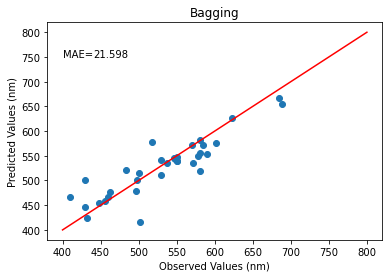

In [60]:
B_regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=16),
                                      n_estimators=6,
                                      random_state=50)
B_regr.fit(X_train, np.ravel(Y_train))
            
B_Y_pred = B_regr.predict(X_test)
            
B_mae = mean_absolute_error(Y_test, B_Y_pred)
print("Mean absolute error =", round(B_mae,3))

plt.figure()
plt.title("Bagging")
plt.plot(Y_test, B_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(B_mae,3) , fontdict=None)
plt.show()

### 2. Decision Trees

In [10]:
# This is a grid search for three parameters in the Decision Trees algorithm. 
# Parameters are: max_depth, max_features, random_state.
# This gives the best combination of the three parameters for the smallest mean squared error.

min_mae = 99999

min_i, min_j, min_k  = 0, 0, 0

for i in tqdm(range(1, 28)):
    for j in range(1, 28):
        for k in range(2, 45, 1):
            
            DT_regr = DecisionTreeRegressor(max_depth=i,
                                max_features=j,
                                random_state=k)
            
            DT_regr.fit(X_train, Y_train)

            DT_Y_pred = DT_regr.predict(X_test)

            mae = mean_absolute_error(Y_test, DT_Y_pred)
            
            if (min_mae > mae):
                min_mae = mae
                min_i = i
                min_j = j
                min_k = k
            
print(min_mae, min_i, min_j, min_k)

100%|██████████| 27/27 [03:01<00:00,  6.71s/it]

24.85371376811594 10 1 41


### 3. Random Forrest

In [8]:
# This is a grid search for three parameters in the Random Forest algorithm. 
# Parameters are: max_depth, n_estimators, max_features.
# Random_state is set to 45.
# This gives the best combination of the three parameters for the smallest mean squared error.

min_mae = 99999
min_i, min_j, min_k = 0, 0, 0
for i in tqdm(range(1, 27)):
    for j in range(1, 27):
        for k in range(2, 50, 2):
            RF_regr = RandomForestRegressor(max_depth=i, 
                                            n_estimators=j, 
                                            max_features=k,
                                            random_state=45
                                                )
            RF_regr.fit(X_train, np.ravel(Y_train))
            RF_Y_pred = RF_regr.predict(X_test)

            mae = mean_absolute_error(Y_test, RF_Y_pred)
            if (min_mae > mae):
                min_mae = mae
                min_i = i
                min_j = j
                min_k = k
            
print(min_mae, min_i, min_j, min_k)

100%|██████████| 26/26 [06:10<00:00, 14.23s/it]

30.766195817094957 12 24 12


### 4. Extra Trees

In [9]:
# This is a grid search for three parameters in the Extra Trees algorithm. 
# Parameters are: random_state, n_estimators, max_features.

# This gives the best combination of the three parameters for the smallest mean squared error.

min_mae = 99999
min_i, min_j, min_k = 0, 0, 0
for i in tqdm(range(1, 20)):
    for j in range(1, 26):
        for k in range(2, 50, 1):
            ET_regr = ExtraTreesRegressor(n_estimators=i, 
                                            max_features=j,
                                            random_state=k
                                                )
            ET_regr.fit(X_train, np.ravel(Y_train))
            ET_Y_pred = ET_regr.predict(X_test)

            mae = mean_absolute_error(Y_test, ET_Y_pred)
            if (min_mae > mae):
                min_mae = mae
                min_i = i
                min_j = j
                min_k = k
            
print(min_mae, min_i, min_j, min_k)

100%|██████████| 19/19 [05:42<00:00, 18.01s/it]

20.967391304347824 4 11 27


In [ ]:
ET_regr = ExtraTreesRegressor(n_estimators=3, max_features=21, random_state=4)
            
ET_regr.fit(X_train, np.ravel(Y_train))
            
ET_Y_pred = ET_regr.predict(X_test)
            
ET_mae = mean_absolute_error(Y_test, ET_Y_pred)
ET_mse = mean_squared_error(Y_test, ET_Y_pred)
print("Mean absolute error =", round(ET_mae,3),'\n',"Mean squared error =", round(ET_mse,3))

plt.figure()
plt.title("Extra TRees")
plt.plot(Y_test, ET_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(ET_mae,3) , fontdict=None)
plt.show()

### 5. Gradient Boosting

In [10]:
min_mae = 999
min_i, min_j, min_k, min_l = 0, 0, 0.0, 0
for i in tqdm(range(300, 450, 10)):
    for j in range(2, 30, 2):
        for k in np.arange(0.06, 0.22, 0.02):
            for l in range(2, 22, 2):
                GB_regr = GradientBoostingRegressor(n_estimators=i, max_depth=j, learning_rate=k, random_state=l)
                GB_regr.fit(X_train, np.ravel(Y_train))
                GB_Y_pred = GB_regr.predict(X_test)

                mae = mean_absolute_error(Y_test, GB_Y_pred)
                if (min_mae > mae):
                    min_mae = mae
                    min_i = i
                    min_j = j
                    min_k = k
                    min_l = l

print(min_mae, min_i, min_j, min_k, min_l)

100%|██████████| 15/15 [1:20:00<00:00, 320.03s/it]

22.240653668420407 440 4 0.16000000000000003 16


Mean absolute error = 23.779


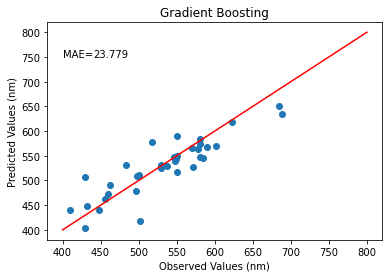

In [46]:
GB_regr = GradientBoostingRegressor(n_estimators=380, max_depth=4, learning_rate=0.18, random_state=6)

            
GB_regr.fit(X_train, np.ravel(Y_train))
            
GB_Y_pred = GB_regr.predict(X_test)
            
GB_mae = mean_absolute_error(Y_test, GB_Y_pred)
print("Mean absolute error =", round(GB_mae,3))

plt.figure()
plt.title("Gradient Boosting")
plt.plot(Y_test, GB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(GB_mae,3) , fontdict=None)
plt.show()

## Conclusion

Extra Trees gave the best performance, **n_estimators=5, max_features=2, random_state=7**

### Saving model

In [11]:
ET_regr = ExtraTreesRegressor(n_estimators=4, max_features=11, random_state=27)

ET_regr.fit(X_train, np.ravel(Y_train))
ET_Y_pred = ET_regr.predict(X_test)

joblib.dump(ET_regr, "./model_aug_abs_ExtraTrees.joblib")

['./model_aug_abs_ExtraTrees.joblib']